## The following is an attempt to predict future cancels in the month of January 2017.

In [1]:
import pandas as pd
import numpy as np
import sys

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
%matplotlib inline

In [2]:
claimDF = pd.read_csv('ClaimLevel.csv')
policyDF = pd.read_csv('PolicyLevel.csv')

In [3]:
claimDF.head()

,PolicyId,ClaimDate,ClaimedAmount,PaidAmount
0,148971,2016-02-11,924.39,814.27
1,566332,2016-01-20,155.43,0.00
2,221990,2016-01-14,1579.88,1136.89
3,568257,2016-01-13,220.33,39.89
4,403218,2016-01-08,46.11,13.87


In [4]:
policyDF.head()

,PolicyId,EnrollDate,CancelDate,MonthlyPremium
0,92597,2010-12-07,NaN,34.54
1,92808,2010-11-09,NaN,18.54
2,93090,2010-11-11,NaN,23.53
3,93122,2010-11-11,NaN,44.02
4,93133,2010-11-11,NaN,32.46


## Checking Data Quality

***

Before making predictions, it's helpful to ascertain the integrity of the information we're using. Our prediction quality might improve if we remove erroneous data. Policy ID numbers carry little meaning and are just unique identifiers, so there is not much of a chance of quality issues with regard to these. In the absence of other information, such as the geographic location of claims associated with a policy or providers with whom claims are solicited, errors in the numbers are difficult to identify or make sense of. Thus, we'll focus more on the other information - policy enrollment and cancellation dates, as well as monthly premiums.

Beginning with monthly premiums, we see that there are no negative values (an obvious error) but there are five values that do not help to current prediction (e.g., NULL values) - the count is 99,995 but we know there are 100,000 records. It would be helpful to remove those before proceeding

In [5]:
policyDF['MonthlyPremium'].describe()

count    99995.000000
mean        27.429644
std         13.084535
min          5.700000
25%         18.530000
50%         24.750000
75%         32.990000
max        171.610000
Name: MonthlyPremium, dtype: float64

In [6]:
policyDF.isnull().sum()

PolicyId              0
EnrollDate            0
CancelDate        86781
MonthlyPremium        5
dtype: int64

In [7]:
policyDF['MonthlyPremium'].size

100000

There is, relatively speaking, a small number of monthly premium values so it seems it would be safe to drop these.

In [8]:
policyDF[policyDF['MonthlyPremium'].isnull()]

,PolicyId,EnrollDate,CancelDate,MonthlyPremium
9932,853115,2016-04-19,2016-04-19,NaN
19108,26042,2009-03-05,2016-01-06,NaN
24364,34475,2010-01-14,NaN,NaN
81853,823753,2016-02-12,2016-10-12,NaN
84772,458540,2014-03-27,2016-10-12,NaN


In [9]:
policyDF = policyDF[np.isfinite(policyDF['MonthlyPremium'])]

In [10]:
policyDF.isnull().sum()

PolicyId              0
EnrollDate            0
CancelDate        86780
MonthlyPremium        0
dtype: int64

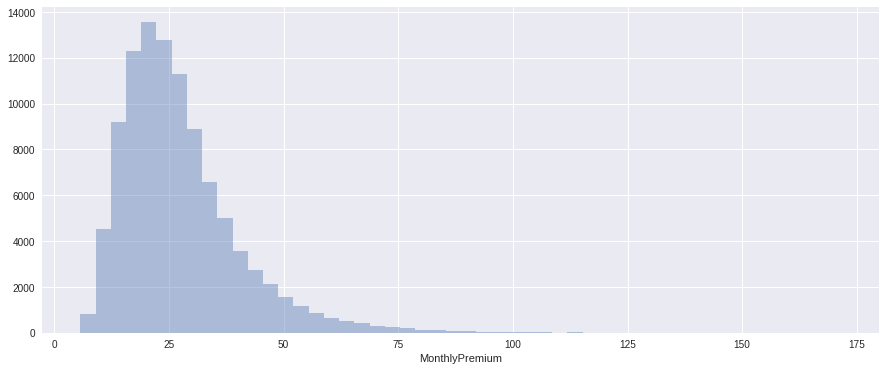

In [11]:
plt.figure(figsize=(15,6))
sns.distplot(policyDF['MonthlyPremium'].dropna(), kde=False)

Further, monthly premiums seem to lie in a sensible right-tailed distribution, with a sensible minimum and without many relatively high values. If we drop the null values, the data still apears sensible. It seems that these values can be used as a predictor. Their predictive power is somewhat dubious, but nevertheless, it seems they can be used as such without great concern.

Next, we consider policy enrollment and cancellation dates. It is difficult to assess whether said dates are erroneous. However, what we can do is evaluate the difference between those two dates to obtain the age of a policy. Since we don't know when data collection ended, policies with null CancelDate values will default to being labelled as having an infinite (thus far) duration.

In [12]:
def pduration(row):
    start = row['EnrollDate']
    end = row['CancelDate']
    if pd.isnull(end):
        """
        If the date of cancellation is null, I assume the policy has not been cancelled.
        Assuming that the data ceased on December 31, 2016, the duration of such policies is
          therefore the difference between January 1, 2017 and the given enrollment date
        """
        return int((datetime(2017,1,1) - datetime.strptime(start, '%Y-%m-%d')).days)
    else:
        """
        Return the difference in days between the enroll and cancel dates. 
        The enroll date should precede the cancel date
        """
        return int((datetime.strptime(end, '%Y-%m-%d') - datetime.strptime(start, '%Y-%m-%d')).days)

policyDF['Duration'] = policyDF.apply(pduration, axis=1)

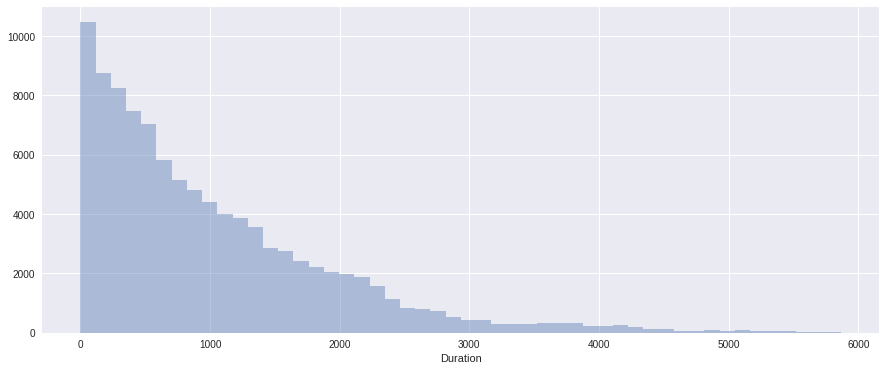

In [13]:
plt.figure(figsize=(15,6))
sns.distplot(policyDF['Duration'].dropna(), kde=False)

There are no negative durations, which would indicate invalid enrollment and cancel dates. Again, we have a right-tailed distribution, so high durations are relatively infrequent. As such, even records with erroneously late cancellation dates, if we could detect these, are unlikely to heavily influence predictions.

In the absence of other information, such as claimed services, it is difficult to assess the legitimacy of claim amounts. Similarly, the correctness of entered paid amounts is difficult to evaluate, as said amounts *should* be less than claim amounts, but the degree of difference is not definite and it would not be impossible for a paid amount to be more than the claim amount. Further, large differences suggest data entry errors but may in fact be accurate and may have motivated a customer's decision as to whether to cancel a policy or not.

***

## Exploration of the Data

Now that we've dealt with some of the data quality issues, let us begin with a relatively naive evaluation. This will show whether further investigation is warranted. If no data is given regarding cancelled policies, it is difficult to say whether policies will be cancelled. In the following, it will be assumed that null CancelDate values (i.e., NaN) indicate policies that have not been cancelled. While it seems plausible that a more insiduous issue is at fault, such as incomplete or erroneous data collection, it does not seem likely that such possibilities may be responsible for such a large amount of null values. The vast majority of CancelDate values are null and it seems sensible that policies without dates of cancellation have not been cancelled. Further, while it seems important to acknowledge that data quality may impede the accuracy of predictions, such will be disregarded in the following.

In [14]:
policyDF['CancelDate'].describe()

count          13215
unique           365
top       2016-09-08
freq             113
Name: CancelDate, dtype: object

In conjunction with the fact that there are 100,000 recorded policies, as of now only about 13.2% of policyholders abandon the service. This is solidified by the following calculation:

In [15]:
(13219 / policyDF['CancelDate'].size) * 100

13.219660983049152

Alternatively, using the assumption that null cancellation dates indicate that a policy has not be cancelled, we can use the ratio of the number of null values in the CancelDate column to the number of given records to find that about 86.8% (100 - 13.2) of customers have not cancelled their policies:

In [16]:
(sum(policyDF['CancelDate'].isnull()) / policyDF['CancelDate'].size) * 100

86.784339216960845

Using this figure, we can naively predict that at most 13.2% of policies will be cancelled at some point in time. In truth, this figure can only be considered to be very rough, as not much information was used to calculate it and predicted cancellations include the possibility of a policy being cancelled in any of the coming months - not merely the month of January in 2017. Further, this model exactly fits the given data and likely would not make accurate predictions given any other data. Thus, further investigation is warranted.

***

It seems intuitive to calculate policy duration. The figure can be used to superficially check the legitimacy of the given dates and perhaps can be used to predict the probability of a policy being cancelled in January 2017 and which policies will either be cancelled later or kept permanently.

In [17]:
def convertTime(string):
    if pd.isnull(string):
        return string
    return datetime.strptime(string, '%Y-%m-%d')

def convertDate(string, kind):
    if pd.isnull(string):
        return string
    """
    Return the date in a useful format.
    Cancellation dates all occur in the year of 2016 so inclusion of the year is unnecessary
    """
    if kind == 'enroll':
        return string.strftime("%b %Y")
    return string.strftime("%b")

def extractFromDate(d, kind):
    if pd.isnull(d):
        return d
    if kind == 'm':
        return int(d.strftime('%-m'))
    return int(d.strftime('%Y'))

Let us take a quick look at our duration values.

In [18]:
print(policyDF['Duration'].dropna().describe())

count    99995.000000
mean      1018.492605
std        933.634760
min          0.000000
25%        318.000000
50%        748.000000
75%       1456.000000
max       5868.000000
Name: Duration, dtype: float64


We hypothesize that a majority of customers (about 68%, assuming that cancellation is normally distributed) likely will not leave in January 2017 if the policies of said customers have a duration in the range of 85 to 1951 days (approximately `1018 - 933` and `1018 + 933`, respectively) by January 2017. This only provides an extremely rough estimate and does not provide a specific probability.

***

Before we go any further, it seems it would be nice to know a bit about the dates we are dealing with.

In [19]:
policyDF['EnrollDate'] = [convertTime(val) for val in policyDF['EnrollDate']]
policyDF['CancelDate'] = [convertTime(val) for val in policyDF['CancelDate']]
policyDF['EnrollDate2'] = [convertDate(date, 'enroll') for date in policyDF['EnrollDate']]
policyDF['EnrollYear'] = [extractFromDate(d,'y') for d in policyDF['EnrollDate']]
policyDF['EnrollMonth'] = [extractFromDate(d,'m') for d in policyDF['EnrollDate']]
policyDF['CancelMonth'] = [extractFromDate(d,'m') for d in policyDF['CancelDate']]

policyDF['CancelDate'].describe()

count                   13215
unique                    365
top       2016-09-08 00:00:00
freq                      113
first     2016-01-01 00:00:00
last      2016-12-31 00:00:00
Name: CancelDate, dtype: object

From the previous cell we see that the policy cancellation dates span the entirety of the year 2016.

Policy enrollment and cancellation dates are a significant portion of the information given, it seems reasonable to investigate their correlatedness with cancellation, including the date of cancellation and the age of a policy when it is cancelled. The previous (given policy cancellation dates all occur in the year 2016) can be used to inform this investigation.

Let us first look at the given enrollment dates.

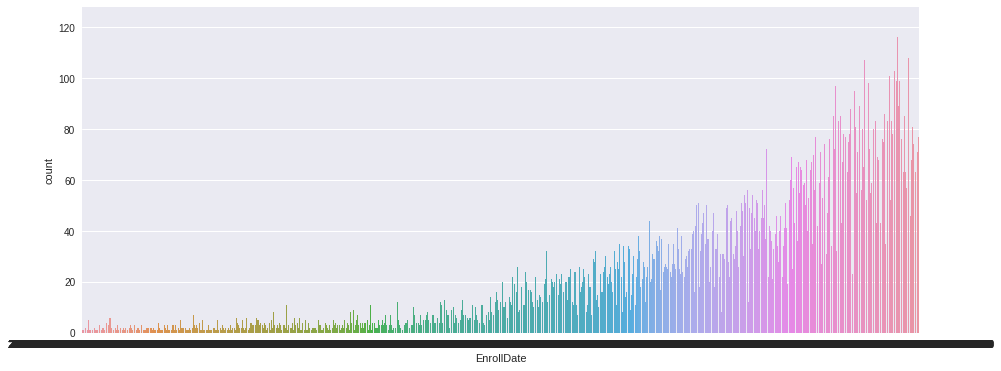

In [20]:
plt.figure(figsize=(15,6))
sns.countplot(data=policyDF, x='EnrollDate')

It appears the number of enrollments grew with time. With this in mind, let us now see if there is an association between enrollment date and whether a policy is cancelled.

Initially, we will consider only policies that have been cancelled.

In [21]:
policyDF['Cancelled'] = policyDF['CancelDate'].notnull()
cancelledPoliciesDF = policyDF[policyDF['Cancelled']]

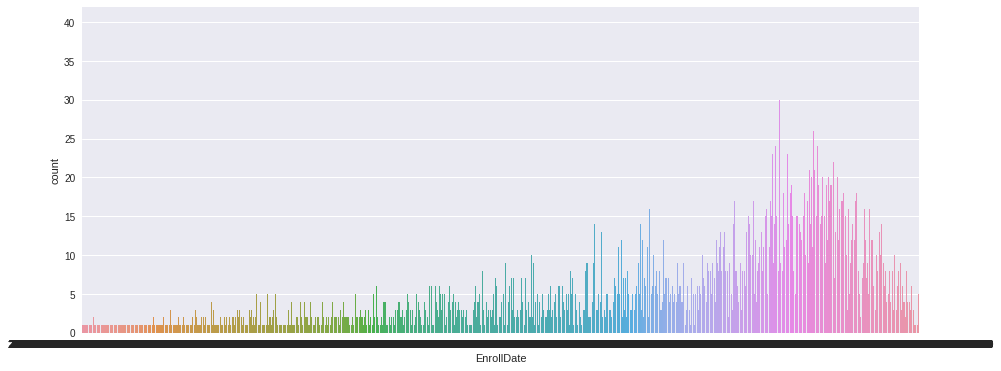

In [22]:
plt.figure(figsize=(15,6))
sns.countplot(data=cancelledPoliciesDF, x='EnrollDate')

The number of enrollments in policies that were eventually cancelled grew with time, but this is reasonable considering that the customer base also grew. For the most part, there seems to be no significant association. The exception would be that the number of customers that would eventually defect spiked then sharply decreased in recent times (i.e., the transition from purple to red bars), suggesting that loyalty was inspired in existing customers, newer customers recruited around that time tended to be relatively loyal, or perhaps another reason. In light of this observation, perhaps it is the case that enrollment dates could inform predictions. Let us examine this observation in more detail with another visualization, as simply zooming in does not seem to be the best strategy.

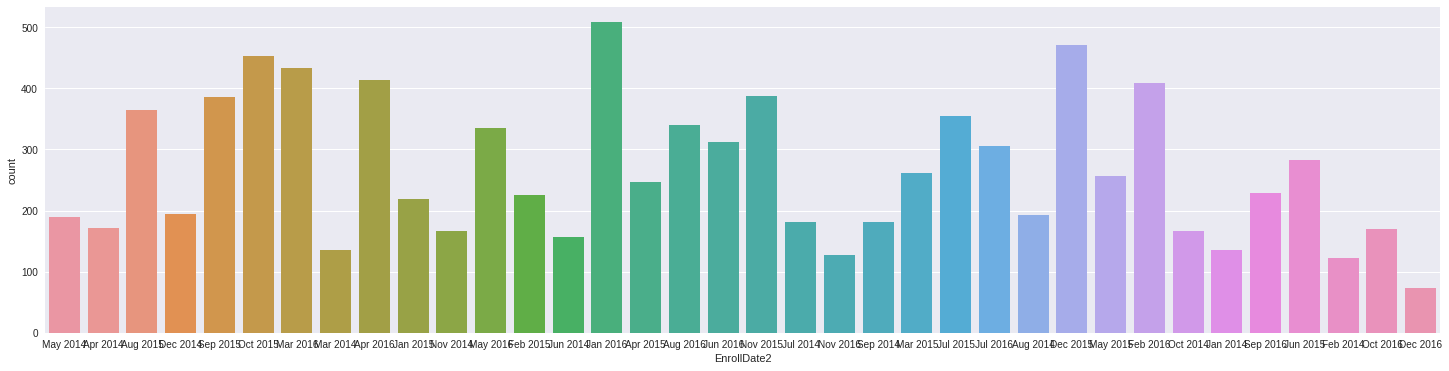

In [23]:
plt.figure(figsize=(25,6))
sns.countplot(data=cancelledPoliciesDF[cancelledPoliciesDF['EnrollYear'] > 2013], x='EnrollDate2')

While it appears that indeed some enrollment dates are associated with more or fewer cancellations than other enrollment dates, the association is not large. Coupled with the fact that the number of enrollments and cancellations both, for the most part, grew smoothly, it does not seem wise to use enrollment date as a predictor of cancellation in January 2017. Up to a certain point (perhaps mid 2015 to early 2016), a later enrollment date should suggest a higher likelihood of cancellation. However, after that point, the trend seems to reverse. This may be because policyholders tend to wait for some time before deciding whether or not to cancel a policy and not enough time has elapsed yet. However, it may also be the case that it takes a large amount of time for data to be entered into the system and to propagate to all users. Further possibilities exist and this visualization did not entirely clear up the matter. At this time, we will assume that enrollment dates do in fact have some predictive power as to when a policy will be cancelled, but not whether a policy will be cancelled. With this, enrollment dates can be used to estimate a _likelihood_ of a policy being cancelled in January 2017

In [24]:
cancelRatios = pd.DataFrame(np.array([[(datetime(2014,1,1) + i * timedelta(days=31)).strftime('%b %Y') for i in range(36)],
                            [0] * 36, [0] * 36, [0] * 36]).T, 
                            columns=["EnrollDate", "Ratio", "Total", "Count"])

In [25]:
def numer(s):
    vals = {'Jan': 1,
           'Feb' : 2,
           'Mar' : 3,
           'Apr' : 4,
           'May' : 5,
           'Jun' : 6,
           'Jul' : 7,
           'Aug' : 8,
           'Sep' : 9,
           'Oct' : 10,
           'Nov' : 11,
           'Dec' : 12}
    return int(s[-2:]) * vals[s[:3]]

dl = list(policyDF['EnrollDate2'].unique())
monthRatios = dict((d,0) for d in dl)
vals = policyDF['EnrollDate2'].value_counts()
for key in monthRatios:
    total = vals[key]
    cancellationData = policyDF[policyDF['EnrollDate2'] == key]['Cancelled'].value_counts()
    if True in cancellationData:
        monthRatios[key] = cancellationData[True] / total

monthRatiosDF = pd.DataFrame(list(monthRatios.items()), columns=['EnrollDate', 'Ratio'])
monthRatiosDF['MonthVals'] = [numer(monthRatiosDF.iloc[i]['EnrollDate']) for i in range(monthRatiosDF['Ratio'].size)]
monthRatiosDF.sort_values('MonthVals', inplace=True)
monthRatiosDF = monthRatiosDF[['EnrollDate', 'Ratio']]

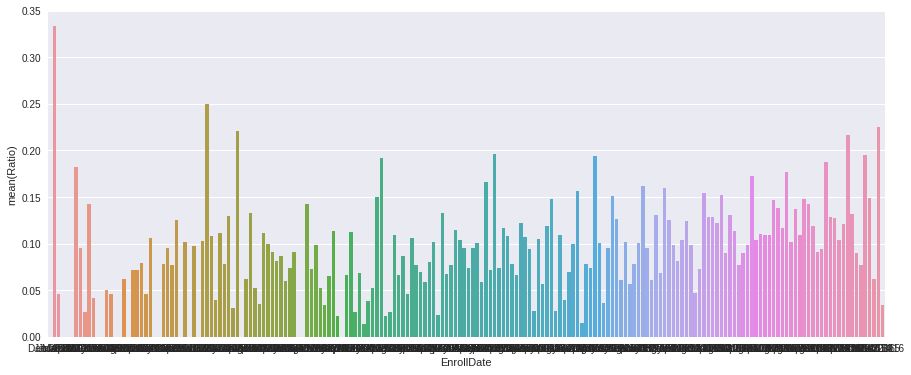

In [26]:
plt.figure(figsize=(15,6))
sns.barplot(data=monthRatiosDF, x='EnrollDate', y='Ratio')

It seems the ratio of enrollees that will eventually cancel fluctuated a bit with time, but the mean increased somewhat until the year 2016. The correlation is strong enough for us to observe visually so it seems reasonable to use enroll dates prior to 2016 as a predictor.

Let us now move on and examine the given cancellation dates.

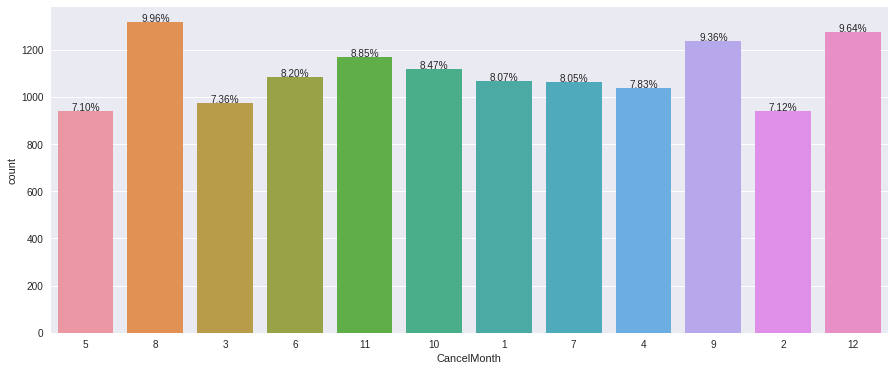

In [27]:
plt.figure(figsize=(15,6))
ax = sns.countplot(data=policyDF, x='CancelMonth')
total = sum(policyDF['CancelMonth'].notnull())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.0, height+3, '{:1.2f}%'.format(100*height/total), ha="center")

If we assume that cancellation dates have perfect predictive power, though, and we simply assume that these cancellation dates are consistent across the years (such cannot be verified here as the given information does not include cancellations in years besides 2016), then we could assign to every extant customer a probability of cancelling in January 2017 of the product of the previously found (approximate) 13.125% and 8.07%. Such does not take into account any other information, though, so these probabilities do not inspire much confidence.

However, from the above, it doesn't seem cancellation dates have much predictive power and thus will not be considered significant in predictions. A relatively large number of customers choose to cancel during months such as August and December whereas a relatively lower number of customers choose to cancel during months such as May and March. However, January is not a month during which many choose to or not to cancel - approximately 8% of customers choose to cancel during January, which is not a great deviation from an expected 8.3 (`100 / 12 ~ 8.3`). 

It is possible, however, that particular types of policies are cancelled more during particular months. Since other information regarding policy types is not at hand, let us estimate if there is any association between the age of a policy and the month it is cancelled.

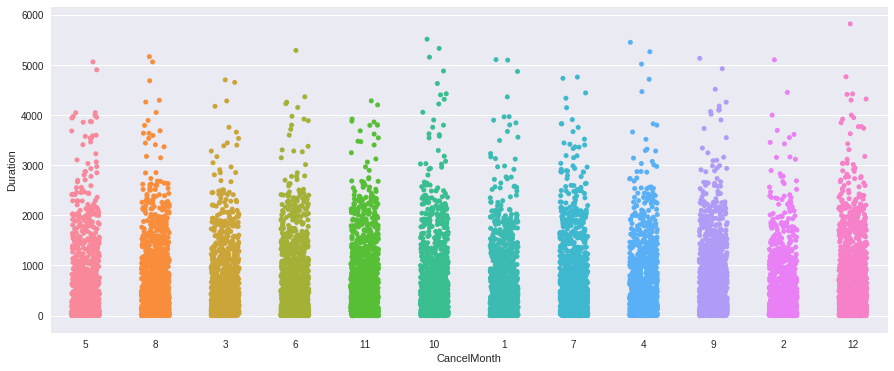

In [28]:
plt.figure(figsize=(15,6))
sns.stripplot(data=policyDF, x='CancelMonth', y='Duration', jitter=0.2)

No particular cancellation month stands out.

Of the given information that remains, we can still check to see if cancellation date is associated with claim history.

Let us start by calculating the percentage of the claim paid, as we will need this figure

In [29]:
claimDF['PercentPaid'] = claimDF.apply(lambda row: 100 * row['PaidAmount'] / row['ClaimedAmount'] if row['ClaimedAmount'] else 100, axis=1)
claimDF['PercentPaid'].describe()

count    144910.000000
mean         45.508118
std          38.504923
min           0.000000
25%           0.000000
50%          49.525640
75%          89.985556
max         297.698086
Name: PercentPaid, dtype: float64

In [30]:
sum(claimDF['PercentPaid'] > 100)

8

(0, 100)

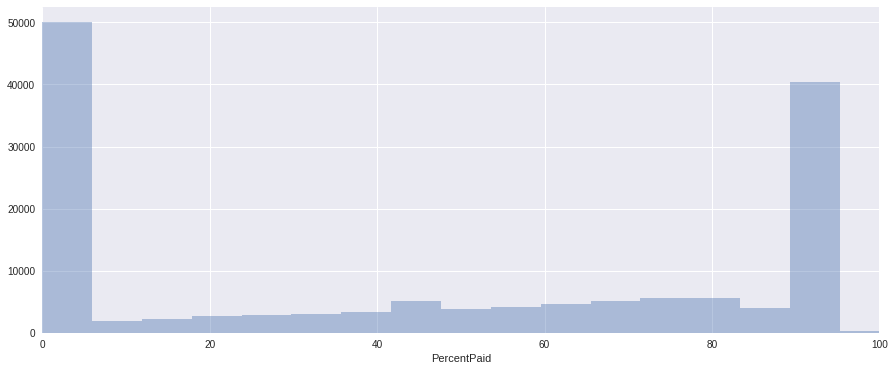

In [31]:
plt.figure(figsize=(15,6))
dp = sns.distplot(claimDF['PercentPaid'], kde=False)
dp.axes.set_xlim(0,100)

The calculated figures appear reasonable. Almost all ratios are below 1 and the majority (about 68%, assuming the payout ratios are normally distributed) of claims have approximately 6.866 to 83.532 (`45.199 - 38.333` and `45.199 + 38.333`) percent of the claim amount paid. Eight claims are paid more than just in full. Again, this could be due to an error in data entry, an error in the determination of the amount to pay, or another reason. If any of these figure is incorrect, said figures should be expunged, but if said figures are representative of actuality, it seems likely that the opinion of a customer was significantly influenced. Since it is difficult to determine the validity of said (potentially influential) ratios with the given information and since said figures are so infrequent, it seems reasonable to retain these figures.

No correlation between PercentPaid values and Cancelled values was investigated above. If multiple PercentPaid values for a policy could be summarized as a single value, perhaps an investigation would be more feasible. However, seeing as how a single policyholder is likely to make multiple claims while other policyholders might make no claims, it seems a correlation would be difficult to investigate. The above has shown that these values are, for the most part, reasonable and therefore may be used. We will move on from this topic now.

Now we need to associate policies with the percent paid to said policies.

In [32]:
policyAndClaimsDF = pd.DataFrame(np.array([claimDF['PolicyId'].unique()]).T,
                                columns=['PolicyId'])
policyAndClaimsDF = pd.merge(policyAndClaimsDF, claimDF[['PolicyId','PercentPaid']], how='left', on='PolicyId')
policyAndClaimsDF.head()

,PolicyId,PercentPaid
0,148971,88.087279
1,148971,79.241087
2,148971,79.354327
3,148971,4.023508
4,148971,82.636132


Further, we see that the number of unique policy ID numbers in the `PolicyLevel.csv` dataset is significantly different from the number of unique policy ID numbers in the `ClaimLevel.csv` dataset.

In [33]:
claimDF['PolicyId'].count()

144910

In [34]:
claimDF['PolicyId'].nunique()

31526

In [35]:
policyDF['PolicyId'].count()

99995

In [36]:
policyDF['PolicyId'].nunique()

99995

This means that not only have some customers had claims paid out to different extents, but also, some customers have not filed any claims whatsoever. This suggests, in addition to the portion of claims being paid for, more information we can use to predict whether a policy will be cancelled in January 2017: the number of claims filed by each customer. In order to use this information, though, we need ID numbers to be in both datasets. Let us verify membership of ID numbers.

In [37]:
common1 = 0
common1ids = []
for num in claimDF['PolicyId']:
    if num in policyDF['PolicyId']:
        common1 += 1
        common1ids.append(num)

common2 = 0
common2ids = []
for num in policyDF['PolicyId']:
    if num in claimDF['PolicyId']:
        common2 += 1
        common2ids.append(num)

print('Number of IDs from claimDF that are in policyDF: {}\nNumber of IDs from policyDF that are in claimDF: {}'.format(common1, common2))
print('Number of IDs that are in both: {}'.format(len(list(set(common1ids) & set(common2ids)))))

Number of IDs from claimDF that are in policyDF: 24659
Number of IDs from policyDF that are in claimDF: 14545
Number of IDs that are in both: 3733


Unfortunately, most ID numbers are not in both datasets. If we wish to use previous information regarding whether or not policies were cancelled, we need to use IDs that are in policyDF. By this reasoning, two choices stand out:
1. `ClaimLevel.csv` is complete. If an ID in policyDF does not occur in claimDF, assume that the owner of this policy did not make any claims.
2. `ClaimLevel.csv` is incomplete. An ID in policyDF that does not occur in claimDF may have associated claims, but said claims just were not recorded to be included in `ClaimLevel.csv`.

In the following, we will assume `(1)`; i.e., that the information in `ClaimLevel.csv` is comprehensive. Let us now include some of the information from `ClaimLevel.csv` with our policy-level data.

In [38]:
policyDF['NumberOfClaims'] = np.zeros(policyDF['PolicyId'].size, dtype=np.int32)
policyDF['PercentagesPaid'] = [[] for i in range(policyDF['PolicyId'].size)]

In [39]:
for i in range(claimDF['PolicyId'].size):
    row = claimDF.iloc[i]
    policyDF.loc[policyDF['PolicyId'] == row['PolicyId'], 'NumberOfClaims'] += 1
#     policyDF.loc[policyDF['PolicyId'] == row['PolicyId'], 'PercentagesPaid'] += [row['PercentPaid'] / 100]

First, let us summarize PercentagesPaid as a single figure for each policy; namely, the harmonic mean of the values. Customer decisions to leave or continue a policy should largely be determined by a consistent payment history, rather than by a high or low percentage of a single claim being paid for. The arithmetic mean gives equal weight to high and low values. The geometric mean does not seem sensible as it is unaffected by a value of one, which should be influence a customer's opinion quite strongly. The harmonic mean is supposedly more sensitive to outliers and in this case, gives more weight to lower values. It seems sensible that lower payments may have a greater absolute effect than higher payments. Thus, the harmonic mean seems more representative of customer thinking and we shall alter the PercentagesPaid column to include the harmonic mean of the values in each list. 

We will consider the harmonic mean of an empty list to be zero.

If an element is zero, the harmonic mean would be undefined. Thus, elements must be modified to account for this. Values that are too low would result in a miniscule harmonic mean. It seems reasonable to use a value of one instead, though the matter is not certain.

In [40]:
def modifyZeros(l):
    nums = []
    for num in l:
        if not num: 
            nums.append(1)
        else:
            nums.append(num)
    return nums

from statistics import harmonic_mean

hmeans = [0] * policyDF['PolicyId'].size
for i in range(policyDF['PolicyId'].size):
    l = policyDF.iloc[i]['PercentagesPaid']
    if not len(l):
        hmeans[i] = 0
    else:
        hmeans[i] = harmonic_mean(modifyZeros(l))

policyDF['PercentagesPaid'] = hmeans
policyDF[['PercentagesPaid', 'Cancelled']].corr()

,PercentagesPaid,Cancelled
PercentagesPaid,NaN,NaN
Cancelled,NaN,1.0


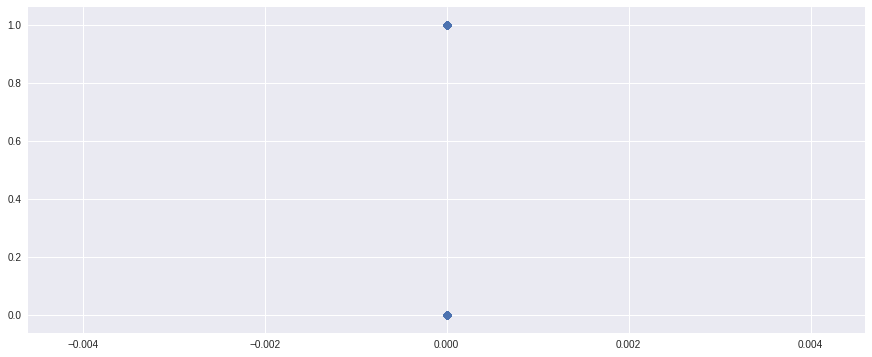

In [41]:
plt.figure(figsize=[15,6])
plt.scatter(policyDF['PercentagesPaid'], policyDF['Cancelled'], alpha=.1)

We see from the above that a correlation probably does not exist. The Pearson correlation calculation is nil and the plot seems to affirm this. It does not seem advisable to use PercentagesPaid values for our predictions

***

Let us now try to see if any obvious correlation exists between MonthlyPremium values and cancellation.

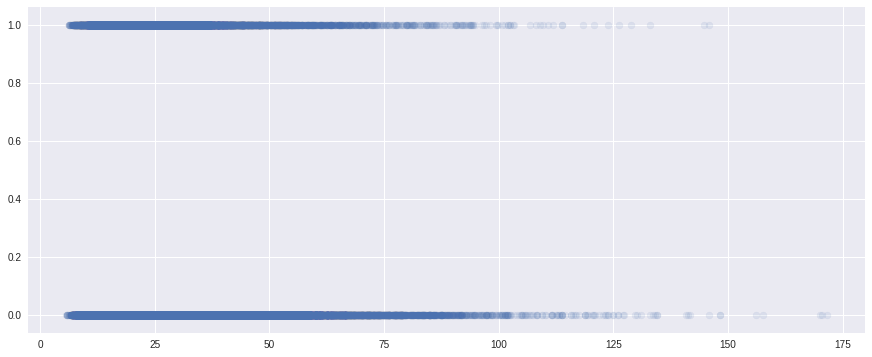

In [42]:
plt.figure(figsize=[15,6])
plt.scatter(policyDF['MonthlyPremium'], policyDF['Cancelled'], alpha=.1)

There seems a large degree of overlap. The MonthlyPremium values of policies that have not been cancelled seems to span a slightly larger range, but it is likely that this is because a far larger number of records are for policies that have not been cancelled as opposed to policies that have been cancelled.

Let us try a different approach. Let us see if one's monthly premium and a policy's duration tells anything about likelihood of cancellation

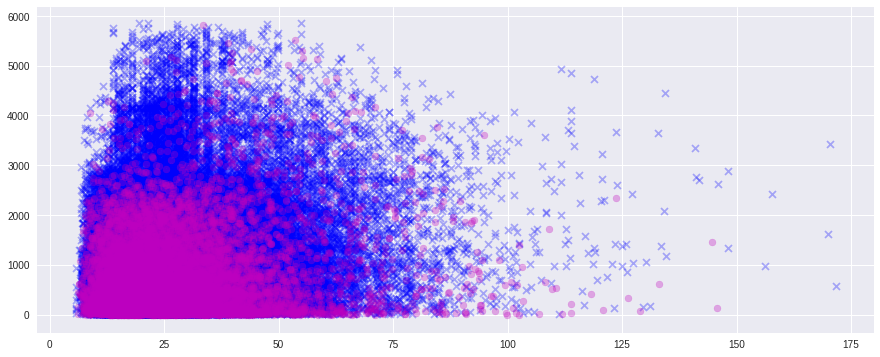

In [43]:
plt.figure(figsize=[15,6])
plt.scatter(policyDF[policyDF['Cancelled'] == 0]['MonthlyPremium'],
            policyDF[policyDF['Cancelled'] == 0]['Duration'],
            marker='x', color='b', alpha=.3)

plt.scatter(policyDF[policyDF['Cancelled'] == 1]['MonthlyPremium'],
            policyDF[policyDF['Cancelled'] == 1]['Duration'],
            marker='o', color='m', alpha=.3)

In [44]:
policyDF['Cancelled'].value_counts()

False    86780
True     13215
Name: Cancelled, dtype: int64

In [45]:
policyDF[['MonthlyPremium', 'Cancelled']].corr()

,MonthlyPremium,Cancelled
MonthlyPremium,1.000000,-0.018964
Cancelled,-0.018964,1.000000


In [46]:
policyDF[['Duration', 'Cancelled']].corr()

,Duration,Cancelled
Duration,1.000000,-0.134086
Cancelled,-0.134086,1.000000


Initially, it may seem that customers who have had longer policies are more likely to cancel, but considering that there is so much more data of customers that have not cancelled. After consideration, it seems that customers with higher premiums and who have had longer lived policies are marginally less likely to cancel their policies. Considering that an increase in density may be illusory and simply a result of more records overall, it is difficult, from a visual standpoint to assess whether a strong correlation exists. A miniscule and even slightly negative correlation exists if we try to use definitive means (e.g., Pearson correlation). It seems neither Duration nor MonthlyPremium values will help.

Finally, let us see if there is an obvious correlation between one's number of claims and cancellation

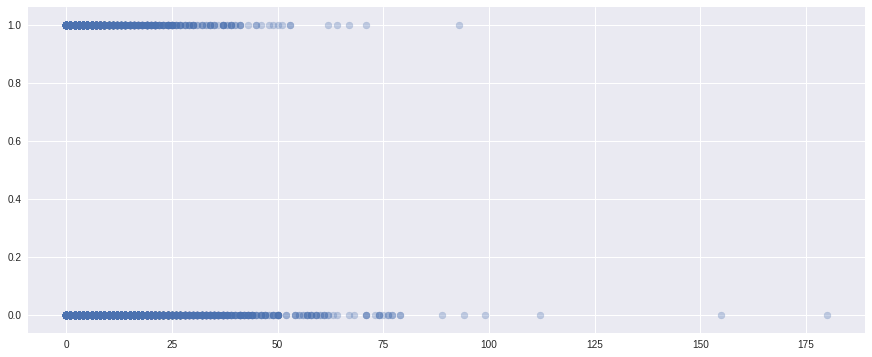

In [47]:
plt.figure(figsize=[15,6])
plt.scatter(policyDF['NumberOfClaims'], policyDF['Cancelled'], alpha=.3)

In [48]:
policyDF[['NumberOfClaims', 'Cancelled']].corr()

,NumberOfClaims,Cancelled
NumberOfClaims,1.000000,-0.021779
Cancelled,-0.021779,1.000000


Again, there is a large amount of overlap. Calculation of Pearson correlation does not help in this case. Again, the resulting figure is very low (approximately 0.02) and slightly negative. We may guess that those who make more claims are marginally less likely to cancel, but the probability of this being true is very slight indeed.

***

## Attempting a Machine Learning Classifier

With the above, it does not seem likely that a machine learning model may accurrately predict cancellation, let alone cancellation in a specific month. Let us give it a quick try, though, as this is only a guess.

A supervised learning paradigm seems most appropriate in this situation. In such a situation, one would require a training dataset and a test dataset. Information regarding cancellations in January 2017 is not given and it is impossible to obtain future data. It makes sense to use as training data input a subset of policies that were enrolled in prior to 2016 and policies that were cancelled in 2016. The output would consist of whether the policies were cancelled in January 2016, cancelled in another month, or not cancelled at all. Accordingly, the test dataset would consist of policies that have not been cancelled and the output on such will serve as predictions as to whether said policies will be cancelled in January 2017. In essence, these predictions would be for cancellation in January 2016 but it seems reasonable to assume that past occurrences provide a sensible predictor of future occurrences.

Let us use a neural network with hidden units. A neural network is based on, to an extent, logistic regression, and thus seems likely to capture the seemingly likely nonlinearities (e.g., if a relationship exists, it seems more likely that MonthlyPolicy values have a nonlinear relationship with probability of cancellation, as I doubt that probabilities will increase or decrease infinitely as MonthlyPolicy values change accordingly). Furthermore, logistic regression presumes linearly separable classes, which seems like a highly unlikely presumption in this case. Hidden units seem to increase the chance of capturing elusive trends. With a multilayer perceptron, we have a better chance of capturing more complex, nonlinear functions, which intuitively are probably involved here, especially given the previous correlation coefficients.

Let us try to get a better idea of how much data we may train on. If we use cancelled policies as a constituent of the train set, then our train set consists of 13,215 policies that were cancelled in 2016 and 1,067 policies that were cancelled in January of 2016.

In [49]:
policyDF['Cancelled'].value_counts()

False    86780
True     13215
Name: Cancelled, dtype: int64

In [50]:
policyDF[policyDF['CancelMonth'] == 1]['PolicyId'].size

1067

In the following, policies are assigned a class label of 0 if they are never cancelled (up until the data of data recording, of course), 1 if they are cancelled in January 2016, and 2 if they are cancelled in January 2017

In [51]:
cancelClassCol = [0 for i in range(policyDF['PolicyId'].size)]

In [52]:
for i in range(policyDF['PolicyId'].size):
    row = policyDF.iloc[i]
    if row['Cancelled']:
        if row['CancelMonth'] == 1:
            cancelClassCol[i] = 1
        else:
            cancelClassCol[i] = 2

In [53]:
policyDF['CancelClass'] = cancelClassCol

We will split the test data as such. Both the training and test data will consist of policies that were not cancelled, policies cancelled in January 2016 and policies that were cancelled in another month in 2016. The test data will consist of 30% of all examples. No discrimination based on cancellation date is made as to which set a policy is assigned to unless the labels for each set do not contain members from all classes (not cancelled, cancelled in January 2016, and cancelled in another month in 2016)

In [54]:
policyDF["CancelMonth"].fillna(0, inplace=True)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(policyDF[['PolicyId', 'MonthlyPremium', 'EnrollYear', 'EnrollMonth', 'CancelMonth', 'NumberOfClaims', 'CancelClass']]),
    cancelClassCol, test_size=0.3)

Let us check to see whether both the test and train sets received examples from each class (0, 1, 2)

In [56]:
print('y_train:')
print(pd.Series(y_train).value_counts())

y_train:
0    60683
2     8575
1      738
dtype: int64


In [57]:
print('\ny_test:')
print(pd.Series(y_test).value_counts())


y_test:
0    26097
2     3573
1      329
dtype: int64


The distributions appear to be usable.

In [58]:
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=8)]

classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[10, 20, 10], n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efe2d4453c8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpqfz1dtpi'}


In [59]:
classifier.fit(X_train, y_train, steps=80000, batch_size=128)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb6e9b35e48>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpwzbtpcwi'}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled

INFO:tensorflow:global_step/sec: 860.434
INFO:tensorflow:loss = 42.9419, step = 5401 (0.116 sec)
INFO:tensorflow:global_step/sec: 988.894
INFO:tensorflow:loss = 76.0496, step = 5501 (0.101 sec)
INFO:tensorflow:global_step/sec: 941.859
INFO:tensorflow:loss = 43.303, step = 5601 (0.106 sec)
INFO:tensorflow:global_step/sec: 860.985
INFO:tensorflow:loss = 87.3263, step = 5701 (0.116 sec)
INFO:tensorflow:global_step/sec: 684.665
INFO:tensorflow:loss = 58.6417, step = 5801 (0.147 sec)
INFO:tensorflow:global_step/sec: 661.583
INFO:tensorflow:loss = 95.8169, step = 5901 (0.150 sec)
INFO:tensorflow:global_step/sec: 949.834
INFO:tensorflow:loss = 135.115, step = 6001 (0.106 sec)
INFO:tensorflow:global_step/sec: 904.711
INFO:tensorflow:loss = 148.245, step = 6101 (0.110 sec)
INFO:tensorflow:global_step/sec: 997.955
INFO:tensorflow:loss = 123.295, step = 6201 (0.100 sec)
INFO:tensorflow:global_step/sec: 968.78
INFO:tensorflow:loss = 112.894, step = 6301 (0.103 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:loss = 48.2102, step = 13801 (0.103 sec)
INFO:tensorflow:global_step/sec: 940.391
INFO:tensorflow:loss = 11.9974, step = 13901 (0.107 sec)
INFO:tensorflow:global_step/sec: 906.945
INFO:tensorflow:loss = 13.0382, step = 14001 (0.109 sec)
INFO:tensorflow:global_step/sec: 1007.11
INFO:tensorflow:loss = 15.0929, step = 14101 (0.099 sec)
INFO:tensorflow:global_step/sec: 1014.02
INFO:tensorflow:loss = 0.0377354, step = 14201 (0.098 sec)
INFO:tensorflow:global_step/sec: 924.401
INFO:tensorflow:loss = 42.2358, step = 14301 (0.108 sec)
INFO:tensorflow:global_step/sec: 958.389
INFO:tensorflow:loss = 37.1052, step = 14401 (0.106 sec)
INFO:tensorflow:global_step/sec: 895.09
INFO:tensorflow:loss = 6.1173, step = 14501 (0.111 sec)
INFO:tensorflow:global_step/sec: 979.012
INFO:tensorflow:loss = 23.9455, step = 14601 (0.102 sec)
INFO:tensorflow:global_step/sec: 958.926
INFO:tensorflow:loss = 44.1614, step = 14701 (0.105 sec)
INFO:tensorflow:global_step/sec: 957.387
INFO:tensorflow:loss

INFO:tensorflow:loss = 30.1584, step = 22201 (0.112 sec)
INFO:tensorflow:global_step/sec: 842.829
INFO:tensorflow:loss = 1.12064, step = 22301 (0.119 sec)
INFO:tensorflow:global_step/sec: 1025.55
INFO:tensorflow:loss = 9.31182, step = 22401 (0.097 sec)
INFO:tensorflow:global_step/sec: 909.149
INFO:tensorflow:loss = 9.57148, step = 22501 (0.110 sec)
INFO:tensorflow:global_step/sec: 928.831
INFO:tensorflow:loss = 19.6454, step = 22601 (0.108 sec)
INFO:tensorflow:global_step/sec: 919.574
INFO:tensorflow:loss = 14.2216, step = 22701 (0.112 sec)
INFO:tensorflow:global_step/sec: 971.772
INFO:tensorflow:loss = 2.09634, step = 22801 (0.100 sec)
INFO:tensorflow:global_step/sec: 999.572
INFO:tensorflow:loss = 23.3641, step = 22901 (0.100 sec)
INFO:tensorflow:global_step/sec: 1024.07
INFO:tensorflow:loss = 8.03324, step = 23001 (0.098 sec)
INFO:tensorflow:global_step/sec: 909.382
INFO:tensorflow:loss = 40.714, step = 23101 (0.110 sec)
INFO:tensorflow:global_step/sec: 893.614
INFO:tensorflow:loss 

INFO:tensorflow:loss = 30.3001, step = 30601 (0.119 sec)
INFO:tensorflow:global_step/sec: 886.359
INFO:tensorflow:loss = 2.65582, step = 30701 (0.113 sec)
INFO:tensorflow:global_step/sec: 908.594
INFO:tensorflow:loss = 26.1027, step = 30801 (0.111 sec)
INFO:tensorflow:global_step/sec: 1034.76
INFO:tensorflow:loss = 18.4317, step = 30901 (0.096 sec)
INFO:tensorflow:global_step/sec: 963.636
INFO:tensorflow:loss = 38.6505, step = 31001 (0.104 sec)
INFO:tensorflow:global_step/sec: 1131.88
INFO:tensorflow:loss = 11.1462, step = 31101 (0.088 sec)
INFO:tensorflow:global_step/sec: 929.022
INFO:tensorflow:loss = 1.80772, step = 31201 (0.108 sec)
INFO:tensorflow:global_step/sec: 919.02
INFO:tensorflow:loss = 14.7971, step = 31301 (0.111 sec)
INFO:tensorflow:global_step/sec: 925.582
INFO:tensorflow:loss = 21.1975, step = 31401 (0.106 sec)
INFO:tensorflow:global_step/sec: 909.313
INFO:tensorflow:loss = 0.529345, step = 31501 (0.110 sec)
INFO:tensorflow:global_step/sec: 956.47
INFO:tensorflow:loss 

INFO:tensorflow:global_step/sec: 861.958
INFO:tensorflow:loss = 29.1598, step = 39001 (0.116 sec)
INFO:tensorflow:global_step/sec: 952.223
INFO:tensorflow:loss = 0.498968, step = 39101 (0.105 sec)
INFO:tensorflow:global_step/sec: 1112.09
INFO:tensorflow:loss = 34.4806, step = 39201 (0.090 sec)
INFO:tensorflow:global_step/sec: 1004.24
INFO:tensorflow:loss = 11.9649, step = 39301 (0.099 sec)
INFO:tensorflow:global_step/sec: 811.354
INFO:tensorflow:loss = 15.118, step = 39401 (0.123 sec)
INFO:tensorflow:global_step/sec: 902.461
INFO:tensorflow:loss = 2.77278, step = 39501 (0.111 sec)
INFO:tensorflow:global_step/sec: 962.765
INFO:tensorflow:loss = 0.0652085, step = 39601 (0.104 sec)
INFO:tensorflow:global_step/sec: 833.771
INFO:tensorflow:loss = 2.36465, step = 39701 (0.121 sec)
INFO:tensorflow:global_step/sec: 827.654
INFO:tensorflow:loss = 0.276522, step = 39801 (0.120 sec)
INFO:tensorflow:global_step/sec: 935.779
INFO:tensorflow:loss = 0.754018, step = 39901 (0.106 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 27.2636, step = 47301 (0.112 sec)
INFO:tensorflow:global_step/sec: 865.855
INFO:tensorflow:loss = 17.8973, step = 47401 (0.116 sec)
INFO:tensorflow:global_step/sec: 998.786
INFO:tensorflow:loss = 1.6149, step = 47501 (0.101 sec)
INFO:tensorflow:global_step/sec: 978.448
INFO:tensorflow:loss = 27.6904, step = 47601 (0.101 sec)
INFO:tensorflow:global_step/sec: 900.39
INFO:tensorflow:loss = 1.0654, step = 47701 (0.112 sec)
INFO:tensorflow:global_step/sec: 874.945
INFO:tensorflow:loss = 7.54085, step = 47801 (0.115 sec)
INFO:tensorflow:global_step/sec: 875.451
INFO:tensorflow:loss = 0.0032588, step = 47901 (0.112 sec)
INFO:tensorflow:global_step/sec: 995.515
INFO:tensorflow:loss = 11.3646, step = 48001 (0.102 sec)
INFO:tensorflow:global_step/sec: 934.962
INFO:tensorflow:loss = 0.120809, step = 48101 (0.106 sec)
INFO:tensorflow:global_step/sec: 1004.61
INFO:tensorflow:loss = 0.00589517, step = 48201 (0.100 sec)
INFO:tensorflow:global_step/sec: 903.54
INFO:tensorflow:lo

INFO:tensorflow:global_step/sec: 935.202
INFO:tensorflow:loss = 0.709619, step = 55701 (0.107 sec)
INFO:tensorflow:global_step/sec: 955.401
INFO:tensorflow:loss = 8.56727, step = 55801 (0.105 sec)
INFO:tensorflow:global_step/sec: 861.002
INFO:tensorflow:loss = 0.0992537, step = 55901 (0.116 sec)
INFO:tensorflow:global_step/sec: 938.646
INFO:tensorflow:loss = 4.10285, step = 56001 (0.107 sec)
INFO:tensorflow:global_step/sec: 879.152
INFO:tensorflow:loss = 16.7138, step = 56101 (0.113 sec)
INFO:tensorflow:global_step/sec: 997.843
INFO:tensorflow:loss = 0.00420988, step = 56201 (0.100 sec)
INFO:tensorflow:global_step/sec: 1041.81
INFO:tensorflow:loss = 2.74935, step = 56301 (0.097 sec)
INFO:tensorflow:global_step/sec: 853.747
INFO:tensorflow:loss = 1.02528, step = 56401 (0.116 sec)
INFO:tensorflow:global_step/sec: 841.338
INFO:tensorflow:loss = 1.92706, step = 56501 (0.119 sec)
INFO:tensorflow:global_step/sec: 933.31
INFO:tensorflow:loss = 2.49813, step = 56601 (0.107 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 922.135
INFO:tensorflow:loss = 2.87245, step = 64001 (0.109 sec)
INFO:tensorflow:global_step/sec: 831.977
INFO:tensorflow:loss = 0.910528, step = 64101 (0.122 sec)
INFO:tensorflow:global_step/sec: 943.132
INFO:tensorflow:loss = 2.18108, step = 64201 (0.104 sec)
INFO:tensorflow:global_step/sec: 828.367
INFO:tensorflow:loss = 10.5294, step = 64301 (0.121 sec)
INFO:tensorflow:global_step/sec: 934.885
INFO:tensorflow:loss = 0.00233955, step = 64401 (0.112 sec)
INFO:tensorflow:global_step/sec: 870.583
INFO:tensorflow:loss = 0.00110363, step = 64501 (0.110 sec)
INFO:tensorflow:global_step/sec: 879.433
INFO:tensorflow:loss = 1.14419, step = 64601 (0.115 sec)
INFO:tensorflow:global_step/sec: 896.583
INFO:tensorflow:loss = 5.27591, step = 64701 (0.111 sec)
INFO:tensorflow:global_step/sec: 897.323
INFO:tensorflow:loss = 18.6061, step = 64801 (0.112 sec)
INFO:tensorflow:global_step/sec: 819.251
INFO:tensorflow:loss = 0.182914, step = 64901 (0.124 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 928.436
INFO:tensorflow:loss = 2.43803, step = 72301 (0.108 sec)
INFO:tensorflow:global_step/sec: 988.656
INFO:tensorflow:loss = 0.441444, step = 72401 (0.101 sec)
INFO:tensorflow:global_step/sec: 1002.78
INFO:tensorflow:loss = 4.67226, step = 72501 (0.105 sec)
INFO:tensorflow:global_step/sec: 866.832
INFO:tensorflow:loss = 0.0854058, step = 72601 (0.112 sec)
INFO:tensorflow:global_step/sec: 900.396
INFO:tensorflow:loss = 0.00490636, step = 72701 (0.109 sec)
INFO:tensorflow:global_step/sec: 955.662
INFO:tensorflow:loss = 0.445738, step = 72801 (0.105 sec)
INFO:tensorflow:global_step/sec: 884.971
INFO:tensorflow:loss = 0.288682, step = 72901 (0.114 sec)
INFO:tensorflow:global_step/sec: 828.105
INFO:tensorflow:loss = 0.120724, step = 73001 (0.121 sec)
INFO:tensorflow:global_step/sec: 935.832
INFO:tensorflow:loss = 3.20987, step = 73101 (0.105 sec)
INFO:tensorflow:global_step/sec: 964.252
INFO:tensorflow:loss = 0.21081, step = 73201 (0.105 sec)
INFO:tensor

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x7fb6fd204b00>, 'hidden_units': [10, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=8, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x7fb719933598>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [60]:
cancellation_preds = list(classifier.predict_classes(X_test))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /tmp/tmpwzbtpcwi/model.ckpt-80000


In [61]:
print(classification_report(y_test, cancellation_preds))

             precision    recall  f1-score   support

          0       0.88      1.00      0.93     25996
          1       0.00      0.00      0.00       327
          2       1.00      0.10      0.18      3676

avg / total       0.88      0.88      0.83     29999



In [62]:
pd.Series(cancellation_preds).value_counts()

0    29630
2      361
1        8
dtype: int64

It appears that the predictions are not very good, even with many fewer or additional training steps (a number of different values in [200, 200000] were attempted) and different settings of hidden layer(s). The proportion of cancellations in January being predicted is far less than our naive assumption of around 1.05%. In itself, such should not be a problem - the predictions would merely be strongly optimistic - but it seems difficult to believe in these predictions. The precision and recall values also seem deceptive considering that there is such a disproportionately large ratio of class 0 examples (i.e., policyholders that have not cancelled). It is very troubling, however, that the f1-scores corresponding to class 1 and class 2 predictions are approximately 0.00 and 0.18, respectively. It makes little sense to continue by constructing a list of probabilities and write that to a file.

***

## More of a Manual Prediction Method

It seems the best possible course of action at this point is to predict cancellation thusly:
* Policies that have already been cancelled have a 0% probability of being cancelled.
Of the remaining policies:
* There is to be a baseline probability, of being cancelled at all, equal to the corresponding ratio in monthRatiosDF. The ratios in monthRatiosDF are the percentage of people who enrolled in a given time frame and cancelled their policies in 2016. The exception, in accordance with the previous observations, would be the year 2016. These policyholders will be assigned a probability equivalent to that of policyholders that enrolled in 2015. This is based on the assumption, which may not be valid, that the 2015 percentages should be quite similar to the 2016 percentages.
* The baseline probability of being cancelled in January is the product of the former baseline percentage and 8.07%. 0.0807 was found previously as the proportion of the number of policies cancelled in January 2016 to the number of policies cancelled in other months of 2016.
* The probability of a policy being cancelled is further adjusted by its value of a feature such as MonthlyPremium, weighted by the Pearson correlation between that feature and cancellation.

As a side note: based on the correlations in the given data, the higher a customer's monthly premium, the less likely the customer is to cancel his or her policy; similarly, the greater the age of the policy, the less likely cancellation is; the greater the number of claims, the less likely cancellation is; and the higher the percentage of the customer's claims having been paid, the less likely the customer is to cancel.

In [64]:
predictionData = policyDF[['PolicyId', 'Cancelled', 'MonthlyPremium', 'Duration', 'NumberOfClaims']]
policyDF['Cancelled'] = policyDF['Cancelled'].astype(int)
stddevs = {'Cancelled'      : policyDF['Cancelled'].describe()['std'], 
         'MonthlyPremium' : policyDF['MonthlyPremium'].describe()['std'],
         'Duration'       : policyDF['Duration'].describe()['std'],
         'NumberOfClaims' : policyDF['NumberOfClaims'].describe()['std']}
cancellationProbabilities = np.zeros(shape=(policyDF['PolicyId'].size, 5))

In [65]:
corr_vals = predictionData.corr()['Cancelled']
features = list(corr_vals.index)
for i in range(policyDF['PolicyId'].size):
    row = policyDF.iloc[i]
    cancellationProbabilities[i][0] = row['PolicyId']
    if not row['Cancelled']:
        baseline_prob = monthRatiosDF[monthRatiosDF['EnrollDate'] == row['EnrollDate2']]['Ratio'].iloc[0] * 0.0807
        for j in range(2, len(features)):
            """
            These policies haven't been cancelled so their value in that column is 0. 
            If we include that correlation, we have the addition of (1 * 0 / 100 = 0).
            
            Correlation is related to how much an increase in the independent variable is associated
            with an increase in the dependent variable. In this case, our dependent variable
            is whether one will cancel or not and the range of values it can assume is [0, 1]. 
            A value of 1 represents that one has cancelled. Put another way, the the correlation value
            is associated with that amount of increase in the dependent variable that results in a 100% increase
            in the probability of cancellation. To be precise, a more precise estimate is the product of the
            correlation and the quotient between the standard deviations of the properties whose
            correlation is being calculated.
            
            We wish to find the likelihood of each party cancelling.
            One approach is to simply take the baseline probability and add the product of the value of 
            each feature and its correlation with cancellation, divided by 100 to account for the fact 
            that each increase of 1 in cancellation value represents a 100% increase in cancellation 
            likelihood, and all divided by 100 to account for the fact that 1 represents 100%.
            However, this presumes that all of the features being considered in addition to "Cancelled" are
            uncorrelated. This is clearly not true. Duration is too intricately correlated with the
            other features, so we cannot consider it if we wish to use the other given features. The same
            goes for many of our other features. It does not seem reasonable to assert that the feature
            values are conditionally independent, either. Further, relationships do not seem likely to be linear.
            In the absence of further information, though, we must assume that they are linear. The results of
            calculations based on estimated nonlinear relationships would be questionable, seeing as how
            the linear relationships found thus far, while weak, are at least relatively certain. It is possible
            that a multiple correlation technique could at least account for some collinearity. The result
            would still be dubious, though, especially considering the nature of the feature Cancelled and 
            the slight nature of the previously found correlations. It is thus difficult to say which
            is likely to be more accurate.
            
            Considering the amount of features that can be used to form predictions, though, it seems
            unwise to abandon the aforementioned approach, as it may be the best available option in
            these circumstances. In other words, it seems that perhaps the best course of action is to 
            compute probabilities modified by each of the given features, and then to take the arithmetic
            mean of the results. To be fair, if conditional independence was a reasonable assumption
            and/or more information was given, it seems likely that far superior predictions could have
            been made, as the present are relatively simple.
            Note that probabilities cannot be negative. In our case, they will not exceed 1, so we must
            only account for negative calculations.
            """
            proba = baseline_prob + (row[features[j]] * corr_vals.iloc[j] * (stddevs[features[j]] / stddevs['Cancelled']) / 10000)
            cancellationProbabilities[i][j-1] = proba if proba >= 0 else 0

Now we have a probability that the policyholder corresponding to each policy will cancel in January 2017. Of course, probabilities range from 0 to 1 and negative probabilities represent a likelihood of 0%. Thus, if we alter our results accordingly, we will have an acceptable set of probabilities from the given information

In [66]:
for i in range(cancellationProbabilities.shape[0]):
    if cancellationProbabilities[i][1]:
        amean = np.mean(cancellationProbabilities[i,1:])
        cancellationProbabilities[i][1] = amean

Now that we have a set of predictions, let us store the results in a dataframe and write them to disk. We can also take a look at our predicted probabilities.

In [67]:
preds = pd.DataFrame(cancellationProbabilities[:,:2], columns=["PolicyId", "Probability"])
preds['Probability'].describe(percentiles=[.25,.26,.99,1])

count    99995.000000
mean         0.004095
std          0.002369
min          0.000000
25%          0.002809
26%          0.002920
50%          0.004181
99%          0.008634
100%         0.012942
max          0.012942
Name: Probability, dtype: float64

In [68]:
vals = [monthRatiosDF['Ratio'].describe()['mean'] * 0.0807, monthRatiosDF['Ratio'].describe()['std'] * 0.0807]
print('68% of baseline ratios should be between: {} and {}\n  (This assumes monthly cancellation ratios are normally distributed)'.format((vals[0] - vals[1]), (vals[0] + vals[1])))

68% of baseline ratios should be between: 0.0028797571603106573 and 0.011623316897245467
  (This assumes monthly cancellation ratios are normally distributed)


In [69]:
.1312566*.0807

0.010592407619999999

The probability values look reasonable and we'll save them. The values do not drop below 0 and more than 74% (99% - 25) are between 0.0028798 and 0.0116 (0.005339 - 0.003318 and 0.005339 + 0.003318, respectively - the baseline mean and standard deviation, respectively). The baseline values presumed uniformity of policyholders (i.e., without regard for the age of relevant policies, the size of monthly payments, etc.) and an extent of randomness, so these percentages, while rough, should be slightly better. However, no greater probabilities were calculated because a linear relationship between features and cancellation was assumed and correlations were negative. With more information and different assumptions, this may have been different. I believe linearity is a dubious assumption but as stated previously, figures with respect to nonlinear relationships would be a result of guesswork and quite questionable. A neural network is based on the principle of logistic regression so the above attempt at using a deep neural network to classify had a chance of capturing the probable nonlinearities, but the corresponding predictions seemed dubious. The recorded predictions, while admittedly rough, at least seem more credible.

Obviously, the probability of cancelling at __any__ time in the future is significantly greater. As per the instructions, though, such probabilities (e.g., any cancellation whatsoever) were not output.

In [70]:
preds.to_csv('cancellation_probabilities.csv', index=False)